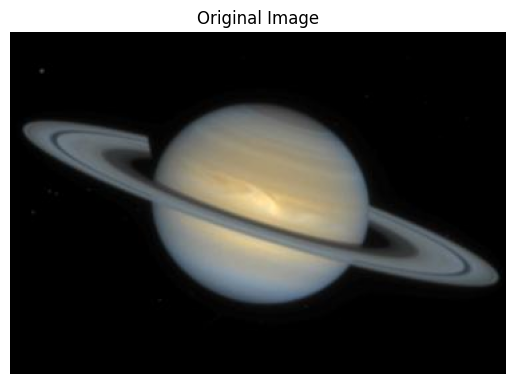

Chromatic aberration (focal length difference):  0.691892698030756
Max output image size:  (1639, 2375)


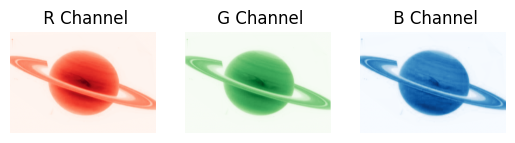

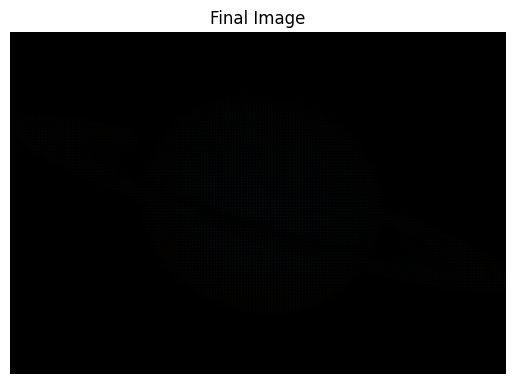

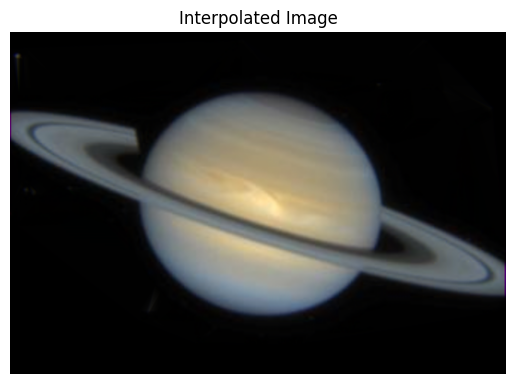

Interpolated image saved to ../results/interpolated_image_achromat.jpg


In [2]:
import sys
sys.path.append('..')

import numpy as np
import cv2 # type: ignore
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from src.utilities import *
from scipy.interpolate import griddata
from src.refractive_idxs import *

# Load the image
image_path = "../assets/PIA01464.jpg" 
#image_path = "../assets/PIA02270.jpg"  
#image_path = "../assets/moon_SC_2016_07_15-1.jpg"
#image_path = "../assets/jupiter-through-a-16-telescope-v0-8w9mx1hyqxwa1.webp"

img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

R, G, B = cv2.split(img_rgb)

n1 = 1.0  # Air

# First doublet parameters
R1_o = 153.7
R2_o = -153.7
R3_o = -706.8
d1_o = 8.4
d2_o = 7
f_o = 300
nR_NBK7 = refractive_index_NBK7(0.700)
nG_NBK7 = refractive_index_NBK7(0.550)
nB_NBK7 = refractive_index_NBK7(0.435)
nR_NSF2 = refractive_index_NSF2(0.700)
nG_NSF2 = refractive_index_NSF2(0.550)
nB_NSF2 = refractive_index_NSF2(0.435)

# Second doublet parameters
R1_e = -42.0
R2_e = 39.5
R3_e = 207.2
d1_e = 2
d2_e = 4.5
f_e = -50
nR_NBAF10 = refractive_index_NBAF10(0.700)
nG_NBAF10 = refractive_index_NBAF10(0.550)
nB_NBAF10 = refractive_index_NBAF10(0.435)
nR_NSF6HT = refractive_index_NSF6HT(0.700)
nG_NSF6HT = refractive_index_NSF6HT(0.550)
nB_NSF6HT = refractive_index_NSF6HT(0.435)

# Reference parameters
n_reference = refractive_index_NBK7(0.5876)
n_ref_NBK7 = refractive_index_NBK7(0.5876)
n_ref_NSF2 = refractive_index_NSF2(0.5876)
n_ref_NBAF10 = refractive_index_NBAF10(0.5876)
n_ref_NSF6HT = refractive_index_NSF6HT(0.5876)

# Reference doublet parameters
refer_fov_i, refer_f_o, refer_f_e, refer_i_angular_pixel_size, refer_i_lateral_pixel_size, refer_output_img_size, refer_M_T, refer_M = get_doublet_parameters(R, n1, n_ref_NBK7, n_ref_NSF2, n_ref_NBAF10, n_ref_NSF6HT, R1_o, R2_o, R3_o,
                                                                                                                      d1_o, d2_o, R1_e, R2_e, R3_e, d1_e, d2_e)

# Calculate parameters of the system for each color channel
fov_iR, f_oR, f_eR, i_angular_pixel_sizeR, i_lateral_pixel_sizeR, output_img_sizeR, M_TR, MR = get_doublet_parameters(R, n1, nR_NBK7, nR_NSF2, nR_NBAF10, nR_NSF6HT, R1_o, R2_o, R3_o, 
                                                                                                                      d1_o, d2_o, R1_e, R2_e, R3_e, d1_e, d2_e)
fov_iG, f_oG, f_eG, i_angular_pixel_sizeG, i_lateral_pixel_sizeG, output_img_sizeG, M_TG, MG = get_doublet_parameters(G, n1, nG_NBK7, nG_NSF2, nG_NBAF10, nG_NSF6HT, R1_o, R2_o, R3_o,
                                                                                                                      d1_o, d2_o, R1_e, R2_e, R3_e, d1_e, d2_e)
fov_iB, f_oB, f_eB, i_angular_pixel_sizeB, i_lateral_pixel_sizeB, output_img_sizeB, M_TB, MB = get_doublet_parameters(B, n1, nB_NBK7, nB_NSF2, nB_NBAF10, nB_NSF6HT, R1_o, R2_o, R3_o,
                                                                                                                      d1_o, d2_o, R1_e, R2_e, R3_e, d1_e, d2_e)


max_f_o = max(f_oR, f_oG, f_oB)
min_f_o = min(f_oR, f_oG, f_oB)
print("Chromatic aberration (focal length difference): ", max_f_o - min_f_o)

# Print the output image size
max_output_img_size = max(output_img_sizeR, output_img_sizeG, output_img_sizeB)
print("Max output image size: ", max_output_img_size)

# Process each channel with the telescope function and the reference parameters
final_imageR = telescope(R, refer_fov_i, refer_f_o, refer_f_e, refer_i_angular_pixel_size, refer_i_lateral_pixel_size, max_output_img_size, M_TR, refer_M)
final_imageG = telescope(G, refer_fov_i, refer_f_o, refer_f_e, refer_i_angular_pixel_size, refer_i_lateral_pixel_size, max_output_img_size, M_TG, refer_M)
final_imageB = telescope(B, refer_fov_i, refer_f_o, refer_f_e, refer_i_angular_pixel_size, refer_i_lateral_pixel_size, max_output_img_size, M_TB, refer_M)

# Final image without interpolation
final_image = cv2.merge((final_imageB, final_imageG, final_imageR))


# Interpolate each channel separately
interpolated_R = griddata(
    np.argwhere(final_imageR > 0), final_imageR[final_imageR > 0],
    (np.indices(final_imageR.shape)[0], np.indices(final_imageR.shape)[1]),
    method='linear', fill_value=0
)

interpolated_G = griddata(
    np.argwhere(final_imageG > 0), final_imageG[final_imageG > 0],
    (np.indices(final_imageG.shape)[0], np.indices(final_imageG.shape)[1]),
    method='linear', fill_value=0
)

interpolated_B = griddata(
    np.argwhere(final_imageB > 0), final_imageB[final_imageB > 0],
    (np.indices(final_imageB.shape)[0], np.indices(final_imageB.shape)[1]),
    method='linear', fill_value=0
)

# Display the interpolated channels
plt.subplot(1, 3, 1)
plt.imshow(interpolated_R, cmap='Reds')
plt.title(' R Channel')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(interpolated_G, cmap='Greens')
plt.title(' G Channel')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(interpolated_B, cmap='Blues')
plt.title(' B Channel')
plt.axis('off')
plt.show()

# Merge the interpolated channels back into a single image
interpolated_image = cv2.merge((interpolated_R, interpolated_G, interpolated_B))

# Show the final image and the interpolated image
plt.imshow(final_image)
plt.title('Final Image')
plt.axis('off')
plt.show()

interpolated_image = np.clip(interpolated_image, 0, 255)
interpolated_image = interpolated_image.astype(np.uint8)

plt.imshow(interpolated_image)
plt.title('Interpolated Image')
plt.axis('off')
plt.show()

# Save the interpolated image
output_path = "../results/interpolated_image_achromat.jpg"
cv2.imwrite(output_path, cv2.cvtColor(interpolated_image, cv2.COLOR_RGB2BGR))
print(f"Interpolated image saved to {output_path}")